In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
import sys
sys.path.append('..')

In [25]:
import csv

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn

from apricot import FeatureBasedSelection
from scipy.stats import multivariate_normal
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.mixture import GaussianMixture
from tqdm import tqdm

seaborn.set_style("whitegrid")

In [26]:
train_data = pd.read_csv("datasets/amazon_reviews/train.csv", header=None)
train_data.columns = ["sentiment", "title", "text"]
# train_data = train_data.sample(frac=0.005)

KeyboardInterrupt: 

In [ ]:
vectorizer = CountVectorizer(max_features=1000)
X_train = vectorizer.fit_transform(train_data["text"])
X_train.shape

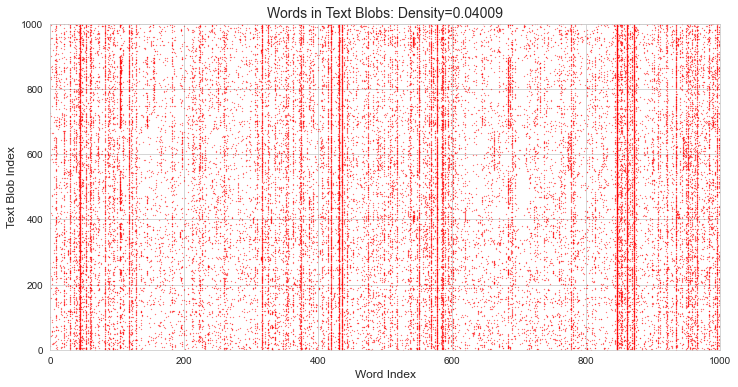

In [20]:
i = 1000

X_random_block = X_train[:i].toarray()
random_density = (X_random_block != 0).mean()

plt.figure(figsize=(12, 6))
plt.scatter(*np.where(X_random_block.T[:i] != 0), c='r', s=0.05)
plt.xlim(0, i)
plt.ylim(0, i)

plt.title("Words in Text Blobs: Density={:4.4}".format(random_density), fontsize=14)
plt.xlabel("Word Index", fontsize=12)
plt.ylabel("Text Blob Index", fontsize=12)
plt.show()

In [21]:
selector = FeatureBasedSelection(n_samples=1000, verbose=True)
selector.fit(X_train)

X_submodular_block = X_train[selector.ranking[:i]].toarray()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.00k/1.00k [06:53<00:00, 2.42it/s]


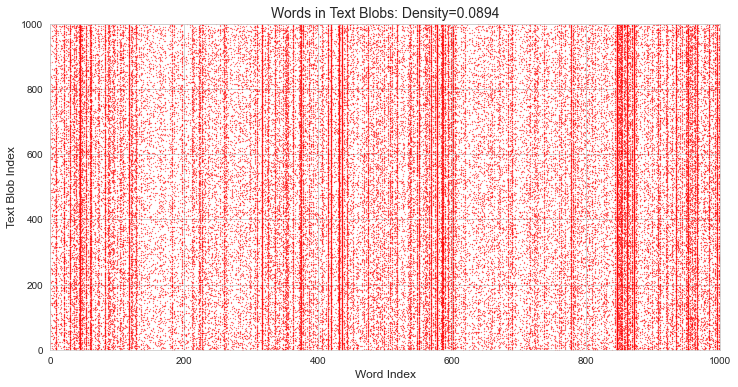

In [22]:
submodular_density = (X_submodular_block != 0).mean()

plt.figure(figsize=(12, 6))
plt.scatter(*np.where(X_submodular_block.T[:i] != 0), c='r', s=0.05)
plt.xlim(0, i)
plt.ylim(0, i)

plt.title("Words in Text Blobs: Density={:4.4}".format(submodular_density), fontsize=14)
plt.xlabel("Word Index", fontsize=12)
plt.ylabel("Text Blob Index", fontsize=12)
plt.show()

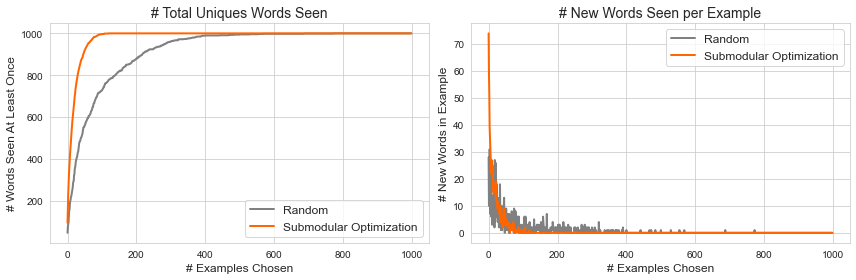

In [9]:
random_seen_words = (np.cumsum(X_random_block, axis=0) > 0).sum(axis=1)
submodular_seen_words = (np.cumsum(X_submodular_block, axis=0) > 0).sum(axis=1)

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.title("# Total Uniques Words Seen", fontsize=14)
plt.plot(random_seen_words, color='0.5', linewidth=2, label="Random")
plt.plot(submodular_seen_words, color='#FF6600', linewidth=2, label="Submodular Optimization")
plt.xlabel("# Examples Chosen", fontsize=12)
plt.ylabel("# Words Seen At Least Once", fontsize=12)
plt.legend(fontsize=12)

plt.subplot(122)
plt.title("# New Words Seen per Example", fontsize=14)
plt.plot(np.diff(random_seen_words), color='0.5', linewidth=2, label="Random")
plt.plot(np.diff(submodular_seen_words), color='#FF6600', linewidth=2, label="Submodular Optimization")
plt.xlabel("# Examples Chosen", fontsize=12)
plt.ylabel("# New Words in Example", fontsize=12)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

## Training an ML model

Name | Loss | N | Precision | Recall
--- | ---  | --- | --- | ---
SOTA FastText | - | - | 0.946 |  0.946
Full dataset raw | 0.241593 | 399990 | 0.916 | 0.916
Full dataset raw (e=30,lr=.5) | 0.194080 | 399990 | 0.913 | 0.913
Full dataset cleaned | 0.249143 | 399990 | 0.912 | 0.912
TFIDF 10k SO | 0.527580 | 399990 | 0.816 | 0.816
Count 10k SO | 0.513048 | 399990 | 0.816 | 0.816

In [14]:
def df_to_fasttxt(df, name):
    df.to_csv(f"datasets/amazon_reviews/{name}.txt", index=False, sep=" ", header=False, quoting=csv.QUOTE_NONE, quotechar="", escapechar=" ")

In [4]:
train_data = pd.read_csv("datasets/amazon_reviews/train.csv", header=None)
train_data.columns = ["sentiment", "title", "text"]
train_data["text"] = train_data["title"] + " : " + train_data["text"]
train_data["text"]= train_data["text"].replace("\n"," ", regex=True).replace("\t"," ", regex=True)
train_data = train_data[["sentiment", "text"]]
train_data = train_data.dropna()
# train_data = train_data.sample(frac=0.005)
train_data["sentiment"] = train_data["sentiment"].apply(lambda x: f"__label__{'positive' if x == 2 else 'negative'}")

test_data = pd.read_csv("datasets/amazon_reviews/test.csv", header=None)
test_data.columns = ["sentiment", "title", "text"]
test_data["text"] = test_data["title"] + " : " + test_data["text"]
test_data["text"]= test_data["text"].replace("\n"," ", regex=True).replace("\t"," ", regex=True)
test_data = test_data[["sentiment", "text"]]
test_data = test_data.dropna()
# test_data = test_data.sample(frac=0.005)
test_data["sentiment"] = test_data["sentiment"].apply(lambda x: f"__label__{'positive' if x == 2 else 'negative'}")

In [5]:
df_to_fasttxt(train_data, "train")
df_to_fasttxt(test_data, "test")

In [16]:
# vectorizer = TfidfVectorizer(max_features=1000)
vectorizer = CountVectorizer(max_features=1000)

X_train = vectorizer.fit_transform(train_data["text"].values)
X_test = vectorizer.transform(test_data["text"].values)

y_train = train_data["sentiment"].values
y_test = test_data["sentiment"].values

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3599923, 10000), (399990, 10000), (3599923,), (399990,))

In [17]:
selector = FeatureBasedSelection(n_samples=10000, verbose=True)
selector.fit(X_train)

idxs = selector.ranking
# df_to_fasttxt(train_data.loc[idxs], "train_tfidf_10k")
df_to_fasttxt(train_data.loc[idxs], "train_count_10k")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10.0k/10.0k [1:01:54<00:00, 2.69it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:01<00:00,  1.64it/s]


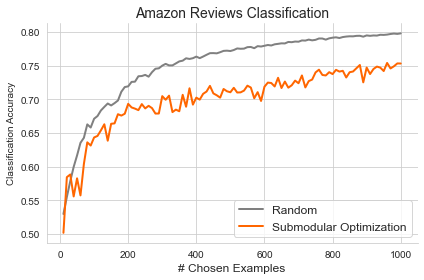

In [72]:
model = SGDClassifier(random_state=0)
counts = np.arange(10, 1001, 10)

random_idxs = np.array([np.random.choice(X_train.shape[0], replace=False, size=1000) for i in range(10)])
random_accuracies, submodular_accuracies = [], []

for count in tqdm(counts):
    idxs = selector.ranking[:count]
    model.fit(X_train[idxs], y_train[idxs])

    y_hat = model.predict(X_test)
    acc = (y_hat == y_test).mean()
    submodular_accuracies.append(acc)
    
    accs = []
    for i in range(10):
        r_idxs = random_idxs[i, :count]
        model.fit(X_train[r_idxs], y_train[r_idxs])

        y_hat = model.predict(X_test)
        acc = (y_hat == y_test).mean()
        accs.append(acc)
    
    random_accuracies.append(accs)

plt.title("Amazon Reviews Classification", fontsize=14)
plt.plot(counts, np.mean(random_accuracies, axis=1), color='0.5', linewidth=2, label="Random")
plt.plot(counts, submodular_accuracies, color='#FF6600', linewidth=2, label="Submodular Optimization")

plt.xlabel("# Chosen Examples", fontsize=12)
plt.ylabel("Classification Accuracy")
plt.legend(loc=4, fontsize=12)

seaborn.despine()
plt.tight_layout()
plt.show()

## Gaussian Mixture Model

In [ ]:
# max_iters = 10
# use diagonal covariance type
# use verbose
model = GaussianMixture(5).fit(X_train.toarray())
X_posteriors = model.predict_proba(X_train.toarray())
X_posteriors.shape

In [27]:
# sum/max redundancy
# reduce num features to 1000 initially
# compare simple count vectorizer to more complex vectorizer (bert standard/sentence vectorizer)